In [1]:
import torch
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration
import requests
from PIL import Image

# Set device to CUDA if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the processor and model, then move the model to the chosen device
processor = Pix2StructProcessor.from_pretrained('google/deplot')
model = Pix2StructForConditionalGeneration.from_pretrained('google/deplot').to(device)



2025-03-09 07:12:05.522967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741504325.540271    4832 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741504325.545586    4832 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 07:12:05.563034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/venv/main/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


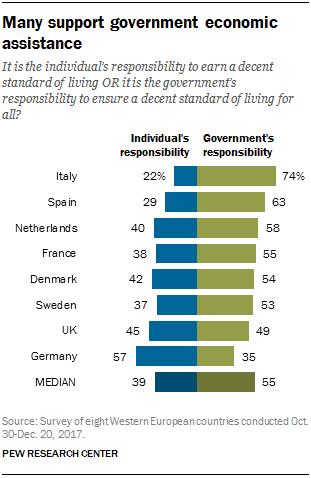

In [3]:

url = "https://raw.githubusercontent.com/vis-nlp/ChartQA/main/ChartQA%20Dataset/val/png/5090.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [4]:

# Prepare inputs and move them to the device
inputs = processor(images=image, text="Generate underlying data table of the figure below:", return_tensors="pt")
inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

# Generate predictions on the GPU
predictions = model.generate(**inputs, max_new_tokens=512)

# Decode and print the output
print(processor.decode(predictions[0], skip_special_tokens=True))


Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, If both images and text are provided, image_processor is not a VQA processor, and `add_special_tokens` is unset, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer. To test the new behavior, set `legacy=False`as a processor call argument.


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:


from IPython.display import  display



import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import cv2


from datasets import load_dataset

ds = load_dataset("MMMU/MMMU_Pro", "vision")

print(ds)

from PIL import Image
import matplotlib.pyplot as plt

# Access the image
image = ds["test"][0]["image"]

# Display the image
plt.imshow(image)
plt.axis("off")  # Remove axes
plt.show()




import torch
from PIL import Image
from transformers import AutoProcessor, Kosmos2ForConditionalGeneration

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the Kosmos-2 model and processor, move the model to the GPU
model_kosmos = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224").to(device)
# model_kosmos = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224").to(device)
processor_kosmos = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")






def get_caption_and_entities_kosmos_2(image_path):
    # Load the image
    image = Image.open(image_path)

    # Define the prompt
    prompt = "<grounding> An image of"

    # Process the input for the model
    inputs = processor_kosmos(text=prompt, images=image, return_tensors="pt").to(device)

    # Move tensors to GPU if available
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}


    # Generate the output
    generated_ids = model_kosmos.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )

    # Decode the output
    generated_text = processor_kosmos.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = processor_kosmos.post_process_generation(generated_text, cleanup_and_extract=False)

    # Extract caption and entities
    caption, entities = processor_kosmos.post_process_generation(generated_text)

    return caption, entities


from PIL import Image, ImageDraw

def apply_bbox_mask(image_path, entities):
    """
    Applies a filter mask to an image, keeping only the pixels within the bounding boxes and blackening the rest.

    Args:
        image_path (str): Path to the input image.
        entities (list): List of tuples containing object descriptions and bounding box information.
                         Each tuple should be in the format:
                         (description, text_range, [bounding_box_list]),
                         where bounding_box_list contains relative coordinates (x_min, y_min, x_max, y_max).

    Returns:
        Image: Processed image with pixels outside the bounding boxes blackened.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Create a mask with the same size as the image
    mask = Image.new("L", image.size, 0)  # "L" mode for grayscale

    # Draw the bounding boxes on the mask
    draw = ImageDraw.Draw(mask)
    for _, _, bboxes in entities:
        for bbox in bboxes:
            # Convert bbox relative coordinates to pixel coordinates
            x_min = int(bbox[0] * image.width)
            y_min = int(bbox[1] * image.height)
            x_max = int(bbox[2] * image.width)
            y_max = int(bbox[3] * image.height)
            # Draw a white rectangle for the bounding box
            draw.rectangle([x_min, y_min, x_max, y_max], fill=255)

    # Apply the mask to the image
    filtered_image = Image.new("RGB", image.size)
    filtered_image.paste(image, mask=mask)

    return filtered_image





# import shutil
# import os

# # Specify the directory to remove
# directory = "/content/Depth-Anything-V2"

# # Check if the directory exists before attempting to remove it
# if os.path.exists(directory):
#     shutil.rmtree(directory)
#     print(f"Directory '{directory}' has been removed successfully.")
# else:
#     print(f"Directory '{directory}' does not exist.")


# Depth anything

!git lfs install
!git clone https://huggingface.co/spaces/depth-anything/Depth-Anything-V2

# !GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/spaces/depth-anything/Depth-Anything-V2

!pip install -r /content/Depth-Anything-V2/requirements.txt
!pip install spaces

import os

# Change to the desired directory
os.chdir("/content/Depth-Anything-V2")

# Verify the current directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")


## Now

import gradio as gr
import cv2
import matplotlib
import numpy as np
import os
from PIL import Image
import spaces
import torch
import tempfile
from gradio_imageslider import ImageSlider
from huggingface_hub import hf_hub_download

from depth_anything_v2.dpt import DepthAnythingV2

import matplotlib


css = """
#img-display-container {
    max-height: 100vh;
}
#img-display-input {
    max-height: 80vh;
}
#img-display-output {
    max-height: 80vh;
}
#download {
    height: 62px;
}
"""
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
encoder2name = {
    'vits': 'Small',
    'vitb': 'Base',
    'vitl': 'Large',
    'vitg': 'Giant', # we are undergoing company review procedures to release our giant model checkpoint
}
encoder = 'vitl'
model_name = encoder2name[encoder]
model = DepthAnythingV2(**model_configs[encoder])
filepath = hf_hub_download(repo_id=f"depth-anything/Depth-Anything-V2-{model_name}", filename=f"depth_anything_v2_{encoder}.pth", repo_type="model")
state_dict = torch.load(filepath, map_location="cpu",weights_only=True)
model.load_state_dict(state_dict)
model = model.to(DEVICE).eval()
cmap = matplotlib.colormaps.get_cmap('Spectral_r')


title = "# Depth Anything V2"
description = """Official demo for **Depth Anything V2**.
Please refer to our [paper](https://arxiv.org/abs/2406.09414), [project page](https://depth-anything-v2.github.io), and [github](https://github.com/DepthAnything/Depth-Anything-V2) for more details."""

@spaces.GPU
def predict_depth(image):
    return model.infer_image(image)



def on_submit(image):
    original_image = image.copy()

    h, w = image.shape[:2]

    depth = predict_depth(image[:, :, ::-1])

    raw_depth = Image.fromarray(depth.astype('uint16'))
    tmp_raw_depth = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
    raw_depth.save(tmp_raw_depth.name)

    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)
    colored_depth = (cmap(depth)[:, :, :3] * 255).astype(np.uint8)

    gray_depth = Image.fromarray(depth)
    tmp_gray_depth = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
    gray_depth.save(tmp_gray_depth.name)

    return [(original_image, colored_depth), tmp_gray_depth.name, tmp_raw_depth.name]



import matplotlib
import numpy as np
import matplotlib.pyplot as plt

image = Image.open("/content/image.jpg")

def make_depth_context_img(image):
    # Convert to a NumPy array
    image_array = np.array(image)

    print("Image loaded as NumPy array:")
    print(image_array.shape)

    all_outputs = on_submit(image_array)

    # Assuming image_array is the original image array and all_outputs[0][1] contains the intensity values
    intensity_image = all_outputs[0][1]  # Image from which we calculate intensity percentiles

    # Get image dimensions
    height, width, channels = image_array.shape

    # Flatten the intensity image to get a list of all pixel intensities
    flattened_intensity_image = intensity_image.reshape(-1, 3)

    # Calculate intensity values for each pixel (using the average of RGB channels)
    intensities = np.mean(flattened_intensity_image, axis=1)

    # Calculate the percentiles
    top30_threshold = np.percentile(intensities, 70)  # 70th percentile for top 30%
    bottom30_threshold = np.percentile(intensities, 30)  # 30th percentile for bottom 30%
    mid40_lower_threshold = np.percentile(intensities, 30)  # 30th percentile
    mid40_upper_threshold = np.percentile(intensities, 70)  # 70th percentile

    # Create masks based on the intensity thresholds
    top30_mask_flat = intensities > top30_threshold
    bottom30_mask_flat = intensities < bottom30_threshold
    mid40_mask_flat = (intensities >= mid40_lower_threshold) & (intensities <= mid40_upper_threshold)

    # Reshape masks to match the original image shape (height, width, channels)
    top30_mask = top30_mask_flat.reshape(height, width, 1)
    bottom30_mask = bottom30_mask_flat.reshape(height, width, 1)
    mid40_mask = mid40_mask_flat.reshape(height, width, 1)

    # Apply masks to the image_array (preserve the regions and set others to black)
    top30_image = np.where(top30_mask, image_array, 0)
    bottom30_image = np.where(bottom30_mask, image_array, 0)
    mid40_image = np.where(mid40_mask, image_array, 0)


    return [top30_image, bottom30_image, mid40_image]



import numpy as np
import matplotlib.pyplot as plt

images = make_depth_context_img(image)

# Plot the images
plt.figure(figsize=(15, 5))
titles = ['Top 30%', 'Bottom 30%', 'Mid 40%']
# images = [top30_image, bottom30_image, mid40_image]

for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()




import numpy as np
from PIL import Image

def get_caption_and_entities_kosmos_2(image_array):
    # Convert the numpy array image to a PIL Image
    image = Image.fromarray(image_array.astype('uint8'))

    # Define the prompt
    prompt = "<grounding> An image of"

    # Process the input for the model
    inputs = processor_kosmos(text=prompt, images=image, return_tensors="pt").to(device)

    # Move tensors to GPU if available
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

    # Generate the output
    generated_ids = model_kosmos.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )

    # Decode the output
    generated_text = processor_kosmos.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = processor_kosmos.post_process_generation(generated_text, cleanup_and_extract=False)

    # Extract caption and entities
    caption, entities = processor_kosmos.post_process_generation(generated_text)

    return caption, entities


location = ["Closest","Mid Range","Farthest"]

for i in range(3):
    image = images[i]
    entities = get_caption_and_entities_kosmos_2(image)

    print(f"{location[i]}: {entities[0]}\n----")






## Whole code

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

image = Image.open("/content/image.jpg")

def make_depth_context_img(image):
    # Convert to a NumPy array
    image_array = np.array(image)

    print("Image loaded as NumPy array:")
    print(image_array.shape)

    all_outputs = on_submit(image_array)

    # Assuming image_array is the original image array and all_outputs[0][1] contains the intensity values
    intensity_image = all_outputs[0][1]  # Image from which we calculate intensity percentiles

    # Get image dimensions
    height, width, channels = image_array.shape

    # Flatten the intensity image to get a list of all pixel intensities
    flattened_intensity_image = intensity_image.reshape(-1, 3)

    # Calculate intensity values for each pixel (using the average of RGB channels)
    intensities = np.mean(flattened_intensity_image, axis=1)

    # Calculate the percentiles
    top30_threshold = np.percentile(intensities, 70)  # 70th percentile for top 30%
    bottom30_threshold = np.percentile(intensities, 30)  # 30th percentile for bottom 30%
    mid40_lower_threshold = np.percentile(intensities, 30)  # 30th percentile
    mid40_upper_threshold = np.percentile(intensities, 70)  # 70th percentile

    # Create masks based on the intensity thresholds
    top30_mask_flat = intensities > top30_threshold
    bottom30_mask_flat = intensities < bottom30_threshold
    mid40_mask_flat = (intensities >= mid40_lower_threshold) & (intensities <= mid40_upper_threshold)

    # Reshape masks to match the original image shape (height, width, channels)
    top30_mask = top30_mask_flat.reshape(height, width, 1)
    bottom30_mask = bottom30_mask_flat.reshape(height, width, 1)
    mid40_mask = mid40_mask_flat.reshape(height, width, 1)

    # Apply masks to the image_array (preserve the regions and set others to black)
    top30_image = np.where(top30_mask, image_array, 0)
    bottom30_image = np.where(bottom30_mask, image_array, 0)
    mid40_image = np.where(mid40_mask, image_array, 0)


    return [top30_image, bottom30_image, mid40_image]



import numpy as np
import matplotlib.pyplot as plt

images = make_depth_context_img(image)

# Plot the images
plt.figure(figsize=(15, 5))
titles = ['Top 30%', 'Bottom 30%', 'Mid 40%']
# images = [top30_image, bottom30_image, mid40_image]


for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()


import numpy as np
from PIL import Image

def get_caption_and_entities_kosmos_2(image_array):
    # Convert the numpy array image to a PIL Image
    image = Image.fromarray(image_array.astype('uint8'))

    # Define the prompt
    prompt = "<grounding> An image of"

    # Process the input for the model
    inputs = processor_kosmos(text=prompt, images=image, return_tensors="pt").to(device)

    # Move tensors to GPU if available
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}

    # Generate the output
    generated_ids = model_kosmos.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )

    # Decode the output
    generated_text = processor_kosmos.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = processor_kosmos.post_process_generation(generated_text, cleanup_and_extract=False)

    # Extract caption and entities
    caption, entities = processor_kosmos.post_process_generation(generated_text)

    return caption, entities



location = ["Closest","Mid Range","Farthest"]

for i in range(3):
    image = images[i]
    entities = get_caption_and_entities_kosmos_2(image)

    print(f"{location[i]}: {entities[0]}\n----")


